<a href="https://colab.research.google.com/github/neevishah/ArtificialIntelligence/blob/master/4_APS360_Lab_4_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, March 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1-rXaQnQSNyE4Ip0q_7Gk0EEzSCXkapWt

In [0]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [0]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [0]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [6]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [7]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [8]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [9]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [10]:
subdf.describe()

,age,yredu,capgain,caploss,workhr
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456
std,13.640433,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
columns_to_normalize = ["age", "yredu", "capgain", "caploss", "workhr"]
scaler = MinMaxScaler()
data_to_normalize = df[columns_to_normalize].values
data_normed = scaler.fit_transform(data_to_normalize)
df_temp = pd.DataFrame(data_normed, columns=columns_to_normalize, index = df.index)
df[columns_to_normalize] = df_temp

In [13]:
df.head()

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States
3,0.493151,Private,234721,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.00000,0.0,0.397959,United-States
4,0.150685,Private,338409,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.00000,0.0,0.397959,Cuba


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [14]:
# hint: you can do something like this in pandas
fraction_male = sum(df["sex"] == " Male")/32561
fraction_female = sum(df["sex"] == " Female")/32561

print("male", fraction_male*100, "%", "female", fraction_female*100, "%")

male 66.92054912318419 % female 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [0]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [0]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing] #~ means not

In [17]:
df.shape

(32561, 11)

In [18]:
df_with_missing.shape

(1843, 11)

In [19]:
df_not_missing.shape

(30718, 11)

1843 records contained missing features and were removed. This is 1843/32561 of the records, or 5.7%.

### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [20]:
set(df_not_missing['work'])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [0]:
data = pd.get_dummies(df_not_missing)

In [22]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [23]:
data.shape

(30718, 57)

There are now 57 columns, because each possible value of each categorical feature got its own column after pd.get_dummies.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

 **We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.**

In [0]:
datanp = data.values.astype(np.float32)

In [0]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)
            #print(cat_values[feature])
            #print(cat_index[feature])

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    return cat_values[feature][onehot.argmax()] 
   #onehot is prediction from nn, find index with max probability to find value

In [26]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [0]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [28]:
print(cat_values, "\n", cat_index)

{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']} 
 {'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}


### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [29]:
datanp

array([[0.30136988, 0.8       , 0.02174022, ..., 0.        , 0.        ,
        1.        ],
       [0.4520548 , 0.8       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.28767124, 0.53333336, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.56164384, 0.53333336, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.06849315, 0.53333336, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.47945204, 0.53333336, 0.15024151, ..., 1.        , 1.        ,
        0.        ]], dtype=float32)

In [30]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

#index labels, randomly shuffle, then split 70%, 15%, 15% 
np.random.shuffle(datanp)

train_index = int(datanp.shape[0] * 0.7)
val_index = int(datanp.shape[0] * 0.85)

train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]

print("# Train Set: " + str(train_set.shape[0]))
print("# Test Set: " + str(val_set.shape[0]))
print("# Val Set: " + str(test_set.shape[0]))

# Train Set: 21502
# Test Set: 4608
# Val Set: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [0]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 40), 
            nn.Linear(40, 20)
        )
        self.decoder = nn.Sequential(
            nn.Linear(20,40),
            nn.Linear(40, 57), 
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The sigmoid activation ensures that the output of the decoder is between 0 and 1. This is the output of the prediction of the autoencoder. 

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [0]:
import matplotlib.pyplot as plt

In [0]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc = [], []
    t_loss, v_loss = [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("epoch: ", epoch, end = " ")
        print("train acc: ", get_accuracy(model, train_loader), end = " ")
        train_acc.append(get_accuracy(model, train_loader))
        print("val acc: ", get_accuracy(model, valid_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        t_loss.append(loss)
        
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        v_loss.append(loss)
      
    return train_acc, val_acc, t_loss, v_loss   

In [0]:
def plot(train_acc, val_acc, t_loss, v_loss):
  plt.title("Training vs Validation Accuracy")
  n = len(train_acc) # number of epochs
  plt.plot(range(1,n+1), train_acc, label="Training")
  plt.plot(range(1,n+1), val_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

  plt.title("Training vs Validation Loss")
  n = len(t_loss) # number of epochs
  plt.plot(range(1,n+1), t_loss, label="Training")
  plt.plot(range(1,n+1), v_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()  

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [0]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch:  0 train acc:  0.4427495116733327 val acc:  0.44169560185185186
epoch:  1 train acc:  0.4582907016401575 val acc:  0.4576461226851852
epoch:  2 train acc:  0.4616857346603417 val acc:  0.45945457175925924
epoch:  3 train acc:  0.5179983257371408 val acc:  0.5184461805555556
epoch:  4 train acc:  0.5308265897745946 val acc:  0.5298394097222222
epoch:  5 train acc:  0.5456081604811955 val acc:  0.5464409722222222
epoch:  6 train acc:  0.560583511611323 val acc:  0.5610894097222222
epoch:  7 train acc:  0.5681874554305026 val acc:  0.5665147569444444
epoch:  8 train acc:  0.5831860602114532 val acc:  0.5805844907407407
epoch:  9 train acc:  0.5919681890056739 val acc:  0.5881438078703703
epoch:  10 train acc:  0.5969057141971289 val acc:  0.5930627893518519
epoch:  11 train acc:  0.60261836108269 val acc:  0.5990668402777778
epoch:  12 train acc:  0.6072303351626205 val acc:  0.6042390046296297
epoch:  13 train acc:  0.6145784888227451 val acc:  0.6110387731481481
epoch:  14 train 

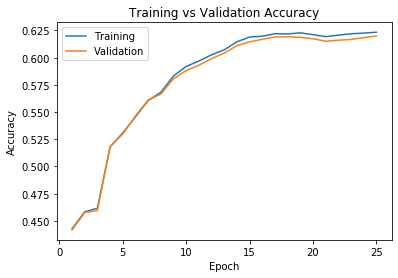

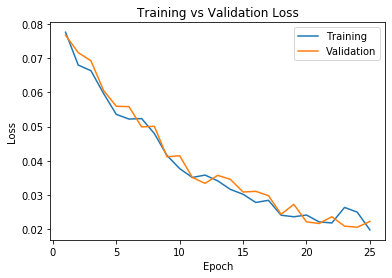

In [68]:
#25 epochs
batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)
autoencoder = AutoEncoder()
train_acc, val_acc, t_loss, v_loss = train(autoencoder, train_loader, valid_loader, num_epochs=25, learning_rate=1e-4)
plot(train_acc, val_acc, t_loss, v_loss)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

epoch:  0 train acc:  0.5717220103556259 val acc:  0.5703486689814815
epoch:  1 train acc:  0.6033004681735032 val acc:  0.6044560185185185
epoch:  2 train acc:  0.6164000248038942 val acc:  0.6160300925925926
epoch:  3 train acc:  0.6170511270269432 val acc:  0.6143663194444444
epoch:  4 train acc:  0.6209964964499426 val acc:  0.6183810763888888
epoch:  5 train acc:  0.6264145970917434 val acc:  0.6265552662037037
epoch:  6 train acc:  0.6303289616469786 val acc:  0.6280020254629629
epoch:  7 train acc:  0.6302281958267448 val acc:  0.6273871527777778
epoch:  8 train acc:  0.6387622856788516 val acc:  0.6367910879629629
epoch:  9 train acc:  0.6415217189098689 val acc:  0.6389250578703703
epoch:  10 train acc:  0.6435680401823086 val acc:  0.6405526620370371
epoch:  11 train acc:  0.6437928254735994 val acc:  0.6414207175925926
epoch:  12 train acc:  0.6456531175394536 val acc:  0.6419632523148148
epoch:  13 train acc:  0.6461957027253279 val acc:  0.6420355902777778
epoch:  14 train

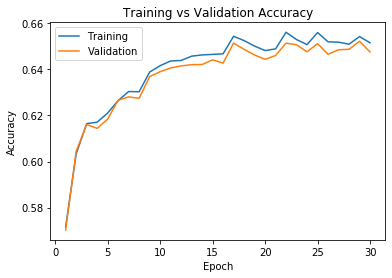

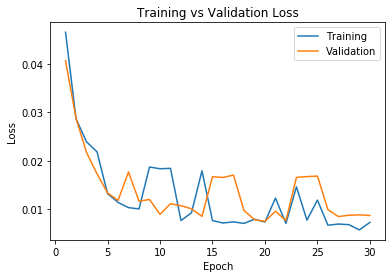

In [55]:
#in previous model, validation accuracy was 61.99%. Loss went from 0.08 to 0.025 for both training and validation. 
#The previous model seems pretty good, so I am going to experiment with increasing the learning rate to see
#if it results in better gradient descent optimization and decreased loss. 

#keep batch size the same, increase learning rate, increase number of epochs to 30 for more training
batch_size=64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

newautoencoder = AutoEncoder()
train_acc, val_acc, t_loss, v_loss = train(newautoencoder, train_loader, valid_loader, num_epochs=30, learning_rate=1e-3)
plot(train_acc, val_acc, t_loss, v_loss)

##Accuracy improved from initial model. 
#The loss is much lower but more volatile, with validation set generally having higher loss, 
#and the accuracy curves are very close to converging.
#Clearly, this model is generalizing almost as well to the validation data as it is to the training data.
#Next, I will try decreasing the learning rate and increasing the batch size, 
#to help stablize the loss and increase the convergence of the accuracy curves.

epoch:  0 train acc:  0.1890134251077419 val acc:  0.18930844907407407
epoch:  1 train acc:  0.20732179952252502 val acc:  0.20764612268518517
epoch:  2 train acc:  0.21665426471956098 val acc:  0.21592881944444445
epoch:  3 train acc:  0.26268099091557373 val acc:  0.2604166666666667
epoch:  4 train acc:  0.3307599293089015 val acc:  0.3302589699074074
epoch:  5 train acc:  0.37539918767246455 val acc:  0.3744574652777778
epoch:  6 train acc:  0.4088224351223142 val acc:  0.4074435763888889
epoch:  7 train acc:  0.40893095215948905 val acc:  0.40747974537037035
epoch:  8 train acc:  0.40893095215948905 val acc:  0.40747974537037035
epoch:  9 train acc:  0.40894645459337114 val acc:  0.40747974537037035
epoch:  10 train acc:  0.4598486962453105 val acc:  0.4585503472222222
epoch:  11 train acc:  0.4598486962453105 val acc:  0.4585503472222222
epoch:  12 train acc:  0.4598486962453105 val acc:  0.4585503472222222
epoch:  13 train acc:  0.4598486962453105 val acc:  0.4585503472222222
epo

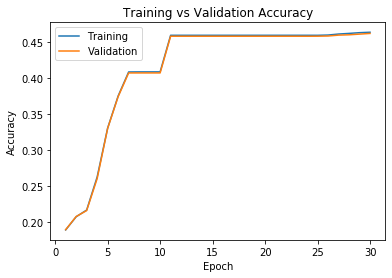

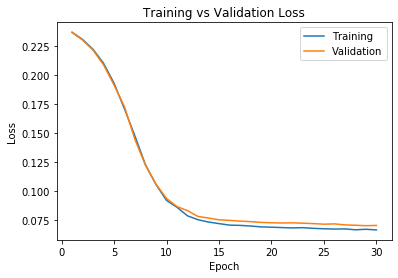

In [70]:
#Increase batch size for faster computation and more accurate gradients, as well as averaging loss over a larger size
#decrease learning rate for smaller step size when calculating gradient descent
batch_size=128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder3 = AutoEncoder()
train_acc, val_acc, t_loss, v_loss = train(autoencoder3, train_loader, valid_loader, num_epochs=30, learning_rate=1.5e-5)
plot(train_acc, val_acc, t_loss, v_loss)

##Accuracy went down and loss went up after decreasing learning rate and increasing batch size. 
#It is likely due to the decreased learning rate.
##The learning rate may be too small to make accurate gradient descent calculations, so this did not end up working out.
##However, the convergence is definitely much better in this version, which was an issue in the previous version.

epoch:  0 train acc:  0.40893095215948905 val acc:  0.40747974537037035
epoch:  1 train acc:  0.4598486962453105 val acc:  0.4585503472222222
epoch:  2 train acc:  0.45972467677425355 val acc:  0.4583695023148148
epoch:  3 train acc:  0.47915697764549037 val acc:  0.47649016203703703
epoch:  4 train acc:  0.5240830310358726 val acc:  0.5255714699074074
epoch:  5 train acc:  0.5316327163364648 val acc:  0.5324435763888888
epoch:  6 train acc:  0.5386553188850649 val acc:  0.5393518518518519
epoch:  7 train acc:  0.5474451988962267 val acc:  0.5487919560185185
epoch:  8 train acc:  0.557599293089015 val acc:  0.5563512731481481
epoch:  9 train acc:  0.5731559854897219 val acc:  0.5718315972222222
epoch:  10 train acc:  0.584457259789787 val acc:  0.5827184606481481
epoch:  11 train acc:  0.5944950857284593 val acc:  0.5923032407407407
epoch:  12 train acc:  0.5971615043561839 val acc:  0.5948712384259259
epoch:  13 train acc:  0.5978668650978204 val acc:  0.5963541666666666
epoch:  14 tr

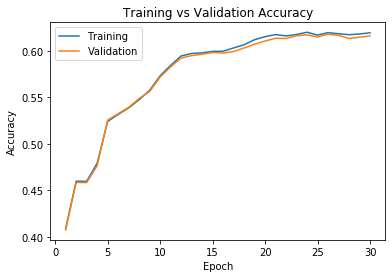

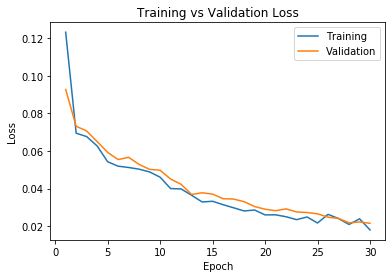

In [71]:
#seems like lowering the learning rate was not useful, so slightly increase.
#keep batch size at 128 for better loss averaging and more accurate gradients
batch_size=128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)

autoencoder4 = AutoEncoder()
train_acc, val_acc, t_loss, v_loss = train(autoencoder4, train_loader, valid_loader, num_epochs=30, learning_rate=1.5e-4)
plot(train_acc, val_acc, t_loss, v_loss)

#Accuracy improved. The model is doing a good job at generalizing to the 
#validation set, as can be seen by the convergence of the training accuracy and validation accuracy curves.
#The increased learning rate therefore seems to have helped increase accuracy.
#The loss curves are a little less smooth compared to before, but the loss is much lower than the previous model.

epoch:  0 train acc:  0.7361020680246799 val acc:  0.4585503472222222
epoch:  1 train acc:  0.7361020680246799 val acc:  0.45988859953703703
epoch:  2 train acc:  0.7345053173348216 val acc:  0.49605758101851855
epoch:  3 train acc:  0.7308699965894645 val acc:  0.5312861689814815
epoch:  4 train acc:  0.7334589030477785 val acc:  0.5474537037037037
epoch:  5 train acc:  0.7335984249527175 val acc:  0.5495876736111112
epoch:  6 train acc:  0.7340092394505937 val acc:  0.5562065972222222
epoch:  7 train acc:  0.7335906737357765 val acc:  0.5647063078703703
epoch:  8 train acc:  0.7343890490807057 val acc:  0.5640552662037037
epoch:  9 train acc:  0.7351254146901064 val acc:  0.5636574074074074
epoch:  10 train acc:  0.7368849409357269 val acc:  0.5690465856481481
epoch:  11 train acc:  0.7376600626298329 val acc:  0.5747251157407407
epoch:  12 train acc:  0.739481598610982 val acc:  0.5753038194444444
epoch:  13 train acc:  0.7395513595634514 val acc:  0.5765335648148148
epoch:  14 trai

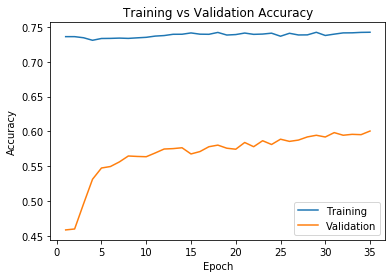

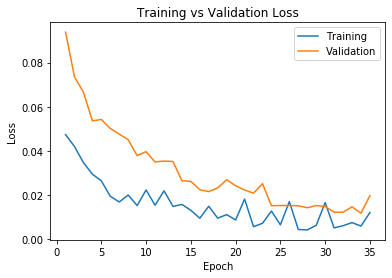

In [0]:
#the higher batch size seems to be helping smooth the loss curves due to it averaging the loss better.
#try an even higher batch size this time.
#Continue to increase learning rate to improve accuracy and reduce loss.
#When the learning rate is too small, the loss will take a very long time to decrease

batch_size=256
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)
autoencoder = AutoEncoder()
train_acc, val_acc, t_loss, v_loss = train(autoencoder, train_loader, valid_loader, num_epochs=35, learning_rate=1.5e-3)
plot(train_acc, val_acc, t_loss, v_loss)

#accuracy improved, although there is still a sizable difference in the training and validation accuracies.
#However, it is within the range that people got on piazza, so this seems to be the average accuracy.
#Loss curves are closer to together and also at lower values compared to before.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [51]:
#use best model, called newautoencoder, which is already trained in the section above.
#had highest accuracy and low loss throughout epochs.
get_accuracy(newautoencoder, test_loader)

0.6527416087962963

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [0]:
np.sum(data)

age                                 9023.342466
yredu                              18697.666667
capgain                              339.755868
caploss                              626.984389
workhr                             12522.071429
work_ Federal-gov                    960.000000
work_ Local-gov                     2093.000000
work_ Private                      22696.000000
work_ Self-emp-inc                  1116.000000
work_ Self-emp-not-inc              2541.000000
work_ State-gov                     1298.000000
work_ Without-pay                     14.000000
marriage_ Divorced                  4258.000000
marriage_ Married-AF-spouse           21.000000
marriage_ Married-civ-spouse       14339.000000
marriage_ Married-spouse-absent      389.000000
marriage_ Never-married             9912.000000
marriage_ Separated                  959.000000
marriage_ Widowed                    840.000000
occupation_ Adm-clerical            3770.000000
occupation_ Armed-Forces               9

In [0]:
train_set

array([[0.09589041, 0.46666667, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.60273975, 0.6       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.24657534, 0.53333336, 0.05178052, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.30136988, 0.4       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.31506848, 0.53333336, 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.1369863 , 0.6       , 0.        , ..., 0.        , 1.        ,
        0.        ]], dtype=float32)

In [0]:
cat_index

{'edu': 33,
 'marriage': 12,
 'occupation': 19,
 'relationship': 49,
 'sex': 55,
 'work': 5}

In [0]:
def most_common_value(data):
  most_common_values = []
  max_index = 0

  for column in range(data.shape[1]):
    count = np.sum(data[:,column])

    if column < 5:
        most_common_values.append(torch.tensor(0.0))
        continue

    if column in cat_index.values():
      most_common_values.append(torch.tensor(count))
      max_index = column
    
    elif most_common_values[max_index] <= count:
      most_common_values[max_index] = torch.tensor(0.0)
      most_common_values.append(torch.tensor(count))
      max_index = column

    else:
      most_common_values.append(torch.tensor(0.0))

  #print(most_common_values)
  for i, value in enumerate(most_common_values):
    if value != 0:
      most_common_values[i] = torch.tensor(1.0)

  return most_common_values

def output_baseline(data, most_common_values):
  #print(most_common_values)
  for column in range(data.shape[1]):
        for row in range(len(data)):
          if data[row,column] == torch.tensor(0.):
            data[row,column] = most_common_values[column]
  return data

In [32]:
baseline=most_common_value(train_set)
print(baseline[19:33])

[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(1.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]


In [0]:
marriagegone=zero_out_feature(test_set, "marriage")
basemarriage= output_baseline(marriagegone, baseline)

In [77]:
get_feature(basemarriage[0], "marriage")

'Married-civ-spouse'

In [79]:
get_features(basemarriage[0])

{'edu': 'HS-grad',
 'marriage': 'Married-civ-spouse',
 'occupation': 'Prof-specialty',
 'relationship': 'Husband',
 'sex': 'Male',
 'work': 'Private'}

In [53]:
edugone=zero_out_feature(test_set, "edu")
baseedu= output_baseline(edugone,baseline)
baseedu

array([[0.65753424, 0.8       , 0.06723067, ..., 0.        , 0.        ,
        1.        ],
       [0.23287672, 0.53333336, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.60273975, 0.53333336, 0.        , ..., 0.        , 1.        ,
        1.        ],
       ...,
       [0.3561644 , 0.53333336, 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.02739726, 0.53333336, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.5068493 , 0.8       , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

In [0]:
get_features(baseedu[0])

{'edu': 'HS-grad',
 'marriage': 'Married-civ-spouse',
 'occupation': 'Prof-specialty',
 'relationship': 'Husband',
 'sex': 'Male',
 'work': 'Private'}

In [0]:
def base_accuracy(data_loader):  
    total = 0
    acc = 0
    for col in catcols:
        #print(col)
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = output_baseline(zero_out_feature(item.clone(), col), most_common_value(train_set)).detach().numpy()
            #print (base1)
            #print(inp)
            #out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(inp.shape[0]): # record in minibatch
              #print(i)
              #print(len(inp),inp[i], "base1 \n", len(base1), base1[i])
              acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
              #print("inp", get_feature(inp[i], col))
              #print(get_feature(out[i], col), "\n")
              #print(out[i], "input", inp[i])
              total += 1
    return acc / total

In [37]:
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1, shuffle=True)
#ok = zero_out_random_feature(test_set)
#base1 = output_baseline(ok, baseline)
base_accuracy(test_loader)

0.4568504050925926

accuracy = 45.685%

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The baseline accuracy is a lot lower than the accuracy of the autoencoder model, implying that the autoencoder is outperforming in comparison to the simple baseline. 

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [0]:
get_features(baseedu[0])

{'edu': 'HS-grad',
 'marriage': 'Married-civ-spouse',
 'occupation': 'Prof-specialty',
 'relationship': 'Husband',
 'sex': 'Male',
 'work': 'Private'}

It is subjective and hard for a human to be able to guess this person's education level based on their other features. You do not know about special circumstances (or whether they dropped out of school but still started a business by themselves). The categories themselves are subjective. However, some assumptions can be made by humans. For instance, I would assume that work in a professional speciality would require additional education beyond high school. 

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [0]:
#run test loader
batch_size = 64
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)
def modelpredict(model, train_loader, test_loader, num_epochs=1, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, test_acc = [], []
    t_loss, te_loss = [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_feature(data.clone(), "edu") # zero out edu feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("epoch: ", epoch, end = " ")
        print("train acc: ", get_accuracy(model, train_loader), end = " ")
        train_acc.append(get_accuracy(model, train_loader))
        print("test acc: ", get_accuracy(model, test_loader))
        test_acc.append(get_accuracy(model, test_loader))
        t_loss.append(loss)
        
        for data in test_loader:
            datam = zero_out_feature(data.clone(), "edu") # zero out edu feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        te_loss.append(loss)
      
    return train_acc, val_acc, t_loss, v_loss, recon

In [130]:
#print out recon and compare to data and see!
autoencoder = AutoEncoder()
train_acc, test_acc, t_loss, te_loss, recon = modelpredict(autoencoder, train_loader, test_loader, num_epochs=1, learning_rate=1e-3)
recon

epoch:  0 train acc:  0.4670340743496729 test acc:  0.4656394675925926


tensor([[3.6079e-01, 6.2758e-01, 3.1537e-02,  ..., 3.2528e-02, 9.8133e-02,
         6.4075e-01],
        [2.4051e-01, 5.9605e-01, 1.8146e-02,  ..., 2.8188e-02, 8.6992e-01,
         1.7058e-01],
        [3.1880e-01, 6.6620e-01, 1.5091e-03,  ..., 8.9079e-04, 4.2144e-04,
         9.7442e-01],
        ...,
        [2.5396e-01, 6.1940e-01, 1.9092e-02,  ..., 2.9706e-02, 8.1405e-01,
         1.8591e-01],
        [3.5352e-01, 6.5014e-01, 2.7738e-03,  ..., 1.4905e-03, 3.2468e-04,
         9.7811e-01],
        [1.8857e-01, 5.7796e-01, 1.0742e-02,  ..., 1.5311e-02, 9.6645e-01,
         1.0386e-01]], grad_fn=<SigmoidBackward>)

In [67]:
get_features(recon[0])

{'edu': 'HS-grad',
 'marriage': 'Married-civ-spouse',
 'occupation': 'Prof-specialty',
 'relationship': 'Husband',
 'sex': 'Male',
 'work': 'Private'}

Given the other features, the model predicted HS-grad. This is after I zero-ed out for education, and then checked the reconstruction. 

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [0]:
get_feature(baseedu[0], "edu") #HS-grade is most common value in train_set, that is what baseline model says

'HS-grad'